# Classification with FNO
Train an FNO timeseries classifier on handcrafted signals with noise as a proof of concept of using an FNO as a classifier.

In [28]:
import importlib
import model_utils
import data_utils
importlib.reload(model_utils)
importlib.reload(data_utils)
from model_utils import FNOClassifier
from data_utils import CustomDataset, RandomSample, RandomTimeTranslateFill0, RandomTimeTranslateReflect, RandomNoise

import os
import optuna
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms

import pytorch_lightning as pl
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
pl.__version__

'2.1.3'

In [29]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU is available on device {torch.cuda.get_device_name(0)} with device count: {torch.cuda.device_count()}")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available on device NVIDIA GeForce RTX 2080 Ti with device count: 1


## Create a dataset

### Original way of generating data: x_train

In [53]:
# Define a function to generate the signals
def generate_signals(start, freqs=[1,0.01,0.1,0.005], noise_std=0.3, class_label=0, time_dim=500):
    # Generate the signal
    if class_label == 0:
        signal = np.sin(2 * np.pi * freqs[0] * np.arange(start, start+time_dim, 1)) + (1/2)*np.sin(2 * np.pi * freqs[1] * np.arange(start, start+time_dim, 1))
    else:
        signal = np.sin(2 * np.pi * freqs[2] * np.arange(start, start+time_dim, 1)) + (1/2)*np.sin(2 * np.pi * freqs[3] * np.arange(start, start+time_dim, 1))

    # Add noise to the signals
    noise = np.random.normal(0, noise_std, time_dim)
    signal += noise

    return signal

# Generate a dataset c consisting of signals, equally split. y should contain label 0 for class 0 and label 1 for class 1
num_examples = 1000
time_dim = 100
x = np.zeros((num_examples, time_dim))
y = np.zeros(num_examples)

data_seed = 30
np.random.seed(data_seed)

for i in range(num_examples):
    if i >= int(num_examples/2):
        y[i] = 1
    
    # Randomly select a start value
    start = np.random.randint(0, num_examples)
    
    x[i] = generate_signals(start=start, class_label=y[i], noise_std=0, time_dim=time_dim)

x shape:  (1000, 1, 100)
Number of classes: 2


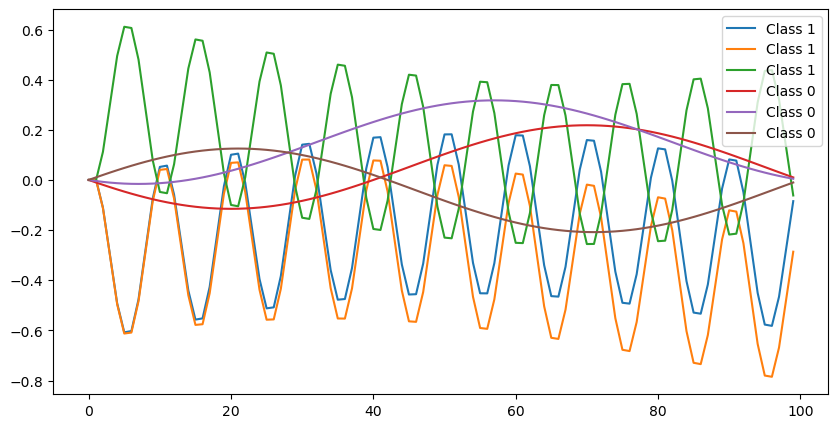

Train set size: 700, Train set class ratio: [0.49857143 0.50142857]
Validation set size: 200, Validation set class ratio: [0.495 0.505]
Test set size: 100, Test set class ratio: [0.52 0.48]


In [54]:
# Reshape the data to be ready for multivariate time-series data (multiple channels)
# Shape is (samples, channels, sequence length)
x = x.reshape((x.shape[0], 1, x.shape[1]))
print("x shape: ", x.shape)

# Count the number of classes
num_classes = len(np.unique(y))
print("Number of classes: " + str(num_classes))

# Scale the data to be between 0 and 1
min_val = 1.5
max_val = -1.5
x = ((x - min_val) / (max_val - min_val))

# Canonicalize the data (pass through 0 at the origin)
x -= x[:, :, 0].reshape(-1, 1, 1)

# Plot a few signals from x_train
plt.figure(figsize=(10, 5))
for i in range(-3, 3, 1):
    plt.plot(x[i, 0, :], label=f"Class {int(y[i])}")
plt.legend()
plt.show()

# Use 20% of training data for validation and 10% for testing
train_set_size = int(0.7 * num_examples)   
valid_set_size = int(0.2 * num_examples)
test_set_size = num_examples - train_set_size - valid_set_size

# split the x_train and y_train set into two
# UPDATE APRIL 24: THIS WAS THE ISSUE WITH MY FNO! Data was not matched with its label :(
# seed = torch.Generator().manual_seed(42)
# x_train, x_valid, x_test = data.random_split(x, [train_set_size, valid_set_size, test_set_size], generator=seed)
# y_train, y_valid, y_test = data.random_split(y, [train_set_size, valid_set_size, test_set_size], generator=seed)

# Don't randomly split the data, sequentially split the data (test set is last 0.1, valid is last 0.3-0.1)
x_train = torch.tensor(x[:train_set_size], dtype=torch.float32)
y_train = torch.tensor(y[:train_set_size], dtype=torch.float32)
x_valid = torch.tensor(x[train_set_size:train_set_size+valid_set_size], dtype=torch.float32)
y_valid = torch.tensor(y[train_set_size:train_set_size+valid_set_size], dtype=torch.float32)
x_test = torch.tensor(x[train_set_size+valid_set_size:], dtype=torch.float32)
y_test = torch.tensor(y[train_set_size+valid_set_size:], dtype=torch.float32)

# Print the size and ratio of classes in train, validation, and test set
print(f"Train set size: {len(x_train)}, Train set class ratio: {np.unique(y_train, return_counts=True)[1] / len(y_train)}")
print(f"Validation set size: {len(x_valid)}, Validation set class ratio: {np.unique(y_valid, return_counts=True)[1] / len(y_valid)}")
print(f"Test set size: {len(x_test)}, Test set class ratio: {np.unique(y_test, return_counts=True)[1] / len(y_test)}")

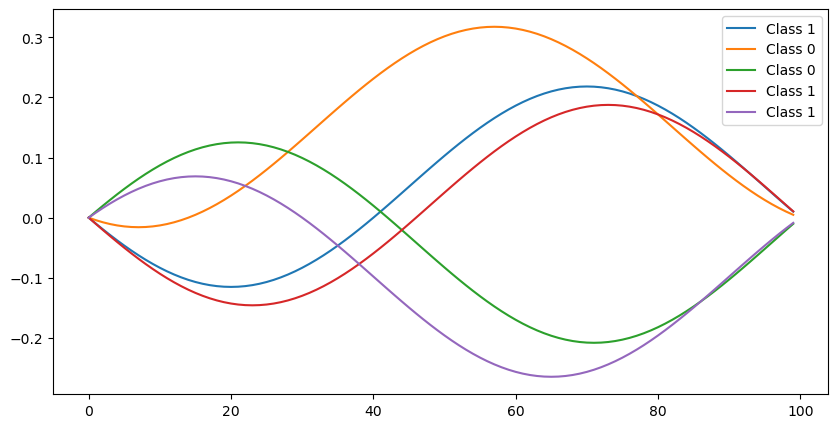

In [56]:
# Plot the first 5 samples from x_train and label by class
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(x_train.dataset[i, 0, :], label=f"Class {int(y_train[i])}")
plt.legend()
plt.show()

### New way of generating data: train_x

In [47]:
# Define a function to generate the signal
def generate_signal(start, freqs=[1,0.01,0.1,0.005], noise_std=0.05, class_label=0, time_dim=100):
    # Generate the signal
    if class_label == 0:
        signal = np.sin(2 * np.pi * freqs[0] * np.arange(start, start+time_dim, 1)) + (1/2)*np.sin(2 * np.pi * freqs[1] * np.arange(start, start+time_dim, 1))
    else:
        signal = np.sin(2 * np.pi * freqs[2] * np.arange(start, start+time_dim, 1)) + (1/2)*np.sin(2 * np.pi * freqs[3] * np.arange(start, start+time_dim, 1))

    # Add noise to the signal
    noise = np.random.normal(0, noise_std, time_dim)
    signal += noise

    return signal

# Define global max and min variables for freqs = [1,0.01,0.1,0.005] and noise_std=0.3
GLOBAL_MAX = 1.5
GLOBAL_MIN = -1.5

# Define a function to reshape, canonacalize, and normalize the signal
def preprocess_signal(signal):
    # Reshape the signal
    signal = signal.reshape((1, len(signal)))

    # Normalize the signal
    signal = (signal - GLOBAL_MIN) / (GLOBAL_MAX - GLOBAL_MIN)

    # TODO: Analyze how this is different from before:
    # x -= x[:, :, 0].reshape(-1, 1, 1)
    # Canonicalize the data (pass through 0 at the origin)
    signal -= signal[:, 0].reshape(1, 1)

    return signal

# Generate a dataset c consisting of signals, equally split. y should contain label 0 for class 0 and label 1 for class 1
total_samples = 1000
time_dim = 100
train_range = [0, int(total_samples*0.7)]
valid_range = [int(total_samples*0.7), int(total_samples*0.9)]
test_range = [int(total_samples*0.9), total_samples]
seed = 42

train_x = []
train_y = []

valid_x = []
valid_y = []

test_x = []
test_y = []

for idx_range in [train_range, valid_range, test_range]:
    num_samples = idx_range[1] - idx_range[0]
    for i in range(num_samples):
        if i < int(num_samples/2):
            label = 0
        else:
            label = 1

        np.random.seed(seed+i)
        
        # Randomly select a start value
        start = np.random.randint(idx_range[0], idx_range[1])
        signal = generate_signal(start=start, class_label=label, noise_std=0, time_dim=time_dim)

        # Preprocess the signal
        signal = preprocess_signal(signal)

        # Append the signal to the data
        if idx_range == train_range:
            train_x.append(signal)
            train_y.append(label)
        elif idx_range == valid_range:
            valid_x.append(signal)
            valid_y.append(label)
        else:
            test_x.append(signal)
            test_y.append(label)

Train x shape:  torch.Size([700, 1, 100])
Train y shape:  torch.Size([700])


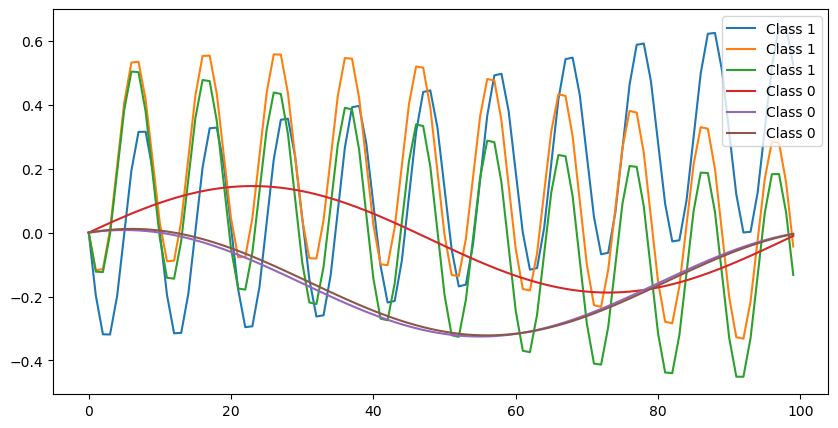

In [48]:
# Turn into torch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
valid_x = torch.tensor(valid_x, dtype=torch.float32)
valid_y = torch.tensor(valid_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

print("Train x shape: ", train_x.shape)
print("Train y shape: ", train_y.shape)

# Plot a few signals from x_train
plt.figure(figsize=(10, 5))
for i in range(-3, 3, 1):
    plt.plot(train_x[i, 0, :], label=f"Class {int(train_y[i])}")
plt.legend()
plt.show()

## Create dataloader

In [49]:
# Create train, valid, and test data loaders
batch_size = 32 # too large of a batchsize crashes the kernel (memory issues due to fft and irfft)
workers = 0
data_augmentation = None
new_data = False # TODO: Investigate this
seq_length = time_dim

if new_data:
        x_train = train_x
        y_train = train_y
        x_valid = valid_x
        y_valid = valid_y
        x_test = test_x
        y_test = test_y


if data_augmentation == "randomsample":
        n_sample = int(0.8*seq_length)
        seq_length = n_sample
        train_loader = DataLoader(
                CustomDataset(
                        x_train, 
                        y_train, 
                        transform=transforms.RandomApply([RandomSample(n_sample=n_sample)], p=1) # Can't be used with other transforms as it changes the shape of the data
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomnoise":
        train_loader = DataLoader(
                CustomDataset(
                        x_train, 
                        y_train, 
                        transform=transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomtimetranslatefill0":
        train_loader = DataLoader(
                CustomDataset(
                        x_train, 
                        y_train, 
                        transform=transforms.RandomApply([RandomTimeTranslateFill0(max_shift=100)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomtimetranslatereflect":
        train_loader = DataLoader(
                CustomDataset(
                        x_train, 
                        y_train, 
                        transform=transforms.RandomApply([RandomTimeTranslateReflect(max_shift=100)], p=0.8)
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )

elif data_augmentation == "randomnoise_randomtimetranslatefill0":
        train_loader = DataLoader(
                CustomDataset(
                        x_train, 
                        y_train, 
                        transform=transforms.Compose([
                                transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.5),
                                transforms.RandomApply([RandomTimeTranslateFill0(max_shift=100)], p=0.5),
                        ])
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )   

elif data_augmentation == "randomnoise_randomtimetranslatereflect":
        train_loader = DataLoader(
                CustomDataset(
                        x_train, 
                        y_train, 
                        transform=transforms.Compose([
                                transforms.RandomApply([RandomNoise(mean=0, std=0.1)], p=0.5),
                                transforms.RandomApply([RandomTimeTranslateReflect(max_shift=100)], p=0.5),
                        ])
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers,
        )    

else:
        train_loader = DataLoader(
                CustomDataset(
                        x_train, 
                        y_train, 
                        transform=None
                ),
                batch_size=batch_size,
                shuffle=True,
                drop_last=True,
                num_workers=workers, 
        )  

valid_loader = DataLoader(
    CustomDataset(x_valid, y_valid),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=workers,
)

test_loader = DataLoader(
    CustomDataset(x_test, y_test),
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    num_workers=workers,
)

# Print the size of a batch and type of data
for x, y in train_loader:
    print("Sample batch of data (batch size, # channels, sequence length): " + str(x.shape))
    print("Sample batch of labels: " + str(y.shape))
    break

# Print number of batches in train and validation set
print(f"Number of batches in train set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(valid_loader)}")

Sample batch of data (batch size, # channels, sequence length): torch.Size([32, 1, 100])
Sample batch of labels: torch.Size([32])
Number of batches in train set: 21
Number of batches in validation set: 6


## Train and test a model

In [50]:
# Hyperparameters
modes = 10
channels = [256, 256, 256, 32] 
pool_type = "avg" 
pooling = seq_length # Remember to change this if using RandomSample augmentation
proj_dim = 32 # Dimension to project to initially
p_dropout = 0.5
add_noise = False

# Optimizers and learning rate schedulers
# lr schedule options are reducelronplateau, steplr, exponentiallr, cosineannealinglr, and cosineannealingwarmrestarts
# optimizer options are sgd or adam
optimizer = "adam"
momentum = 0 # Only used for SGD optimizer
scheduler = "reducelronplateau"
lr = 1e-2

# Initialize classifier
classifier = FNOClassifier(
                modes=modes, 
                lr=lr, 
                channels=channels, 
                pooling=pooling, 
                optimizer=optimizer, 
                scheduler=scheduler, 
                momentum=momentum, 
                pool_type=pool_type, 
                seq_length=seq_length,
                proj_dim=proj_dim,
                p_dropout=p_dropout, 
                add_noise=add_noise
)

# Print the model
print(classifier)

FNOClassifier(
  (loss): BCELoss()
  (project): Sequential(
    (0): Linear(in_features=100, out_features=3200, bias=True)
    (1): Dropout(p=0.5, inplace=False)
  )
  (fno_layer_0): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([32, 256, 6]), rank=None)
      )
    )
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_1): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([256, 256, 6]), rank=None)
      )
    )
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_2): Sequential(
    (0): SpectralConv1d(
      (weight): ModuleList(
        (0): ComplexDenseTensor(shape=torch.Size([256, 256, 6]), rank=None)
      )
    )
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fno_layer_3): Sequential(
    (0):

In [51]:
# Create a tensorboard logger
experiment_name = "signal_dataset_first_pass"
save_directory = "../logs/"

# Check if save_dir/experiment_name exists, if not create it
if not os.path.exists(save_directory + experiment_name):
    os.makedirs(save_directory + experiment_name)

logger = TensorBoardLogger(save_dir=save_directory, name=experiment_name, version=datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S"))
logger.log_hyperparams({
    "modes": modes, 
    "lr": lr, 
    "proj_dim": proj_dim,
    "channels": channels,
    "pool_type": pool_type, 
    "pooling": pooling, 
    "lr_scheduler": scheduler, 
    "batchsize": batch_size, 
    "optimizer": optimizer, 
    "momentum": momentum,
    "p_dropout": p_dropout,
    "add_noise": add_noise,
    "data_augmentation": data_augmentation,
    "neuralop_or_mine": "neuralop_package"
})
print("Tensorboard logs will be saved to: " + logger.log_dir)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=50, mode="min"),
    LearningRateMonitor(logging_interval="step"),
]

# Train the model
trainer = Trainer(max_epochs=1000,
                  logger=logger,
                  callbacks=callbacks,
                  accelerator="auto"
)

trainer.fit(model=classifier, 
            train_dataloaders=train_loader,
            val_dataloaders=valid_loader
)

Tensorboard logs will be saved to: ../logs/signal_dataset_first_pass/2024_04_25-03_10_36


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params | In sizes      | Out sizes    
---------------------------------------------------------------------------
0 | loss        | BCELoss    | 0      | ?             | ?            
1 | project     | Sequential | 323 K  | [1, 1, 100]   | [1, 1, 3200] 
2 | fno_layer_0 | Sequential | 99.1 K | [1, 32, 100]  | [1, 256, 100]
3 | fno_layer_1 | Sequential | 787 K  | [1, 256, 100] | [1, 256, 100]
4 | fno_layer_2 | Sequential | 787 K  | [1, 256, 100] | [1, 256, 100]
5 | fno_layer_3 | Sequential | 98.4 K | [1, 256, 100] | [1, 32, 100] 
6 | dropout     | Dropout    | 0      | [1, 3200]     | [1, 3200]    
7 | fc          | Linear     | 320 K  | [1, 3200]     | [1, 100]     
8 | pool        | AvgPool1d  | 0      | [1, 100]      | [1, 1]       
-----------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [52]:
# Test the model
trainer.test(dataloaders=test_loader)

/home/linneamw/sadow_koastore/personal/linneamw/anaconda3/envs/fno/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at ../logs/signal_dataset_first_pass/2024_04_25-03_10_36/checkpoints/epoch=50-step=1071.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ../logs/signal_dataset_first_pass/2024_04_25-03_10_36/checkpoints/epoch=50-step=1071.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │            1.0            │
│         test_loss         │   1.451624825676845e-06   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.451624825676845e-06, 'test_acc': 1.0}]